# <center>大模型 AI Agent 开发实战

## <center>Ch.8 LangGraph中State状态模式与LangSmith基础使用入门

&emsp;&emsp;在上一小节《Ch.7 LangGraph底层原理与基础应用入门》课程中，我们通过比较`LangChain`中构建`AI Agent`的底层设计解释了`LangGraph`在应对复杂`AI Agent`开发场景中的明显优势。在`LangGraph`框架中，**不论构建的代理简单或复杂，其本质都是通过节点（Node）和边（Edge）的有机组合来形成一个完整的图（Graph）**。这种构建方式所形成的工作流逻辑十分清晰：每个节点在完成其任务后，都会通过边来指示下一个工作步骤，从而赋予整个应用系统更高的灵活性和可扩展性。掌握三个核心组件——状态（State）、节点（Node）和边（Edge），并了解如何使用这些基本元素构建完整的图形结构是学习和应用`LangGraph`框架重要且最基础的一步。通过深入理解这些关键组件足够支撑我们去设计并实现更加复杂且功能丰富的基于`LangGraph`的`AI Agent`应用程序。

&emsp;&emsp;**在`AI Agent`应用程序的设计中，场景的复杂性直接决定了构建图的复杂度。**例如，最简单的场景可能仅涉及一个大模型的问答流程，形式为：START -> Node -> END（其中大模型的交互逻辑被封装在Node中）。而更复杂的场景则可能涉及多个`AI Agent`的协同工作，包括多个分支和循环的构成。无论是简单还是复杂的图，`LangGraph`的价值永远不在于如何去定义节点，如何去定义边，而是在于**如何有效管理各个节点的输入和输出，以保持图的持续运行状态**。`LangGraph`的**底层图算法采用消息传递机制来定义和执行这些图中的交互流程，其中状态（State）组件扮演着关键的载体角色，负责在图的各个节点之间传递信息**。这也就意味着**，`LangGraph`框架的核心在于`State`的有效使用和掌握。在复杂的应用中，`State`组件需要存储和管理的信息量会显著增加。核心功能如工具使用、记忆能力和人机交互等，都依赖`State`来实现和维护**。所以，接下来我们对`LangGragh`框架的探索，都将紧密围绕`State`的实现和应用机制展开，这包括`LangGraph`内置封装好的工具/方法的使用，以及我们自定义构建功能时的实现方法。

&emsp;&emsp;因此，**对于`LangGraph`的底层图算法是利用消息传递机制来定义程序的运行**这一结论，在本节课中，我们将详细探讨消息（Messages）是如何通过`State`进行传递的，其中包含了什么传递模式和内容。

# 1. LangGraph中State的定义模式

&emsp;&emsp;为了更清晰地说明这一过程，我们可以借助如下流程图来理解消息在图结构中的流转过程：👇

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/20241022009.png" width=100%></div>

&emsp;&emsp;`LangGraph`构建的**图中的每个节点都具备访问、读取和写入状态的权限。当某一个节点去修改状态时，它会将此信息广播到图中的所有其他节点。这种广播机制允许其他节点响应状态的变化并相应地调整其行为。**如上图所示，从初始状态（Initial State）开始，其中包含了一条消息 { "x": "10" }，随着消息在节点间通过边传递，每个节点根据其逻辑对状态进行更新。Node 1 和 Node 2 分别对状态进行了处理和变更，结果是在图的末端，我们得到了一个包含三条消息的最终状态 { "x": "10" }, { "x": "11" }, { "y": "9" }。**从开发的角度来看，`State`实际上是一个共享的数据结构。如上图所示，状态表现为一个简单的字典。通过对这个字典进行读写操作，可以实现自左而右的数据流动，从而构建一个可运行的图结构。**那么根据上一节课程学习的内容，我们可以利用这个流程来复现并理解图中的动态数据交换，整体的设计如下：

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/20241022005.png" width=100%></div>

## 1.1 使用字典类型定义状态

&emsp;&emsp;对于上图中的数据场景，我们来实际的进行代码复现。

&emsp;&emsp;首先，我们将图的状态设计为一个字典，用于在不同节点间共享和修改数据，然后使用`StateGraph`类进行图的实例化。代码如下：

In [30]:
from langgraph.graph import StateGraph

# 构建图
builder = StateGraph(dict) 

In [32]:
builder.schema

dict

&emsp;&emsp;接下来，定义两个节点。`addition`节点是一个加法逻辑，接收当前状态，将字典中`x`的值增加1，并返回新的状态。而`subtraction`节点是一个减法逻辑，接收从`addition`节点传来的状态，从字典中的`x`值减去2，创建并返回一个新的键y。

In [34]:
def addition(state):
    print(state)
    return {"x": state["x"] + 1}

def subtraction(state):
    print(state)
    return {"y": state["x"] - 2}

&emsp;&emsp;然后，进行图结构的设计。具体来看，我们添加名为`addition`和`subtraction`的节点，并关联到上面定义的函数。设定图的起始节点为`addition`，并从`addition`到`subtraction`设置一条边，最后从`subtraction`到结束节点设置另一条边。代码如下：

In [36]:
from langgraph.graph import START, END


# 向图中添加两个节点
builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

# 构建节点之间的边
builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

In [38]:
builder.edges

{('__start__', 'addition'),
 ('addition', 'subtraction'),
 ('subtraction', '__end__')}

In [40]:
builder.nodes

{'addition': StateNodeSpec(runnable=addition(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class 'dict'>, retry_policy=None),
 'subtraction': StateNodeSpec(runnable=subtraction(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class 'dict'>, retry_policy=None)}

In [42]:
builder.schema

dict

&emsp;&emsp;最后，执行图的编译。需要通过调用`compile()`方法将这些设置编译成一个可执行的图。代码如下所示：

In [44]:
graph = builder.compile()

&emsp;&emsp;除了上述通过打印的方式查看构建图的结构，`LangGraph`还提供了多种内置的图形可视化方法，能够将任何`Graph`以图形的形式展示出来，帮助我们更好地理解节点之间的关系和流程的动态变化。**可视化最大的好处是：直接从代码中生成图形化的表示，可以检查图的执行逻辑是否符合构建的预期。**`LangGraph`提供的三种图形可视化方法如下：

- **Mermaid.Ink**：一个开源服务，可以根据 Mermaid 代码生成图表的 URL。它通过 API 提供多种输出格式，包括 PNG、JPEG、SVG 和 PDF，并可以自定义尺寸、主题和背景颜色等选项。开源仓库👉：[mermaid](https://github.com/mermaid-js/mermaid)
- **Mermaid + Pyppeteer**：使用 Mermaid 结合 Pyppeteer 的主要区别在于如何将 Mermaid 图表转换成图像或其他格式。Mermaid 本身是一个轻量级的工具，用于通过文本描述生成图表的图形表示。而 Pyppeteer 是一个 Python 库，它提供了一个接口来控制 Chrome，自动打开包含 Mermaid 图表的网页，然后通过浏览器自动截图功能捕获这些图表，生成图像文件。
- **Graphviz**：Graphviz 是一个图形可视化软件，主要用于自动图形布局。它非常适合于复杂图形的生成，如有向图和无向图，而且它支持多种格式的图像输出，如 PNG、SVG、PDF 等，有更精细的布局控制。

> https://langchain-ai.github.io/langgraph/how-tos/visualization/

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022191827626.png" width=90%></div>

&emsp;&emsp;如果是`Linux`操作系统，建议使用`Graphviz`工具。而`Windows`系统建议使用`Mermaid + Pyppeteer`方法，因为在`Windwos`中`Graphviz`并不能直接通过 `pip install`的形式安装，编译安装的方法较为复杂。这里我们就使用`Mermaid + Pyppeteer`来进行图的可视化操作。首先，在当前的虚拟环境中安装依赖包，执行如下代码：

In [25]:
# ! pip install pyppeteer ipython

&emsp;&emsp;生成图结构的可视化非常直接，只需一行代码即可完成。具体代码如下：


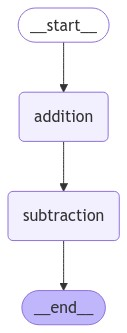

In [46]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

&emsp;&emsp;当通过 `builder.compile()` 方法编译图后，编译后的 `graph` 对象提供了 `invoke` 方法，该方法用于启动图的执行。我们可以通过 `invoke` 方法传递一个初始状态（如 `initial_state = {"x": 10}`），这个状态将作为图执行的起始输入。代码如下：

In [33]:
# 定义一个初始化的状态
initial_state = {"x":10}

graph.invoke(initial_state)

{'x': 10}
{'x': 11}


{'y': 9}

&emsp;&emsp;在图的执行过程中，每个节点的函数会被调用，并且接收到前一个节点返回的状态作为输入。每个函数处理完状态后，会输出一个新的状态，传递给下一个节点。这里需要注意的一个关键信息是：**节点函数不需要返回整个状态，而是仅返回它们更新的部分。**也就是说：在每个节点的函数内部逻辑中，需要使用和更新哪些`State`中的参数中，只需要在`return`的时候指定即可，不必担心未在当前节点处理的State中的其他值会丢失，因为LangGraph的内部机制已经自动处理了状态的合并和维护。

&emsp;&emsp;上述代码执行过程中图的运行状态如下图所示：👇

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/202410220010.png" width=100%></div>

&emsp;&emsp;总体来看，该图设置了一个简单的工作流程。其中值首先在第一个节点通过加法函数增加，然后在第二个节点通过减法函数减少。这一流程展示了节点如何通过图中的共享状态进行交互。需要注意的是，**状态在任何给定时间只包含来自一个节点的更新信息。这意味着当节点处理状态时，它只能访问与其特定操作直接相关的数据，从而确保每个节点的逻辑是隔离和集中的。**使用字典作为状态模式非常简单，**由于缺乏预定义的模式，节点可以在没有严格类型约束的情况下自由地读取和写入状态，这样的灵活性有利于动态数据处理。**然而，这也要求开发者在整个图的执行过程中保持对键和值的一致性管理。因为如果在任何节点中尝试访问`State`中不存在的键，会直接中断整个图的运行状态。

&emsp;&emsp;到此为止，我们可以来思考一个问题：既然所有节点都会向状态（State）发出更新，为什么仅通过返回需要更新的键值，就能实现状态的全局共享呢？除此之外，如果我们需要对状态进行更复杂的操作，如新增、删除或修改等，应该如何构造这些操作呢？这就引出了我们需要深入理解的概念——在 `LangGraph` 中如何利用 `Reducer` 函数来精细控制状态的变化。

## 1.2 Reducer函数的机制

&emsp;&emsp;`LangGraph`内部**原理是：`State`中的每个`key`都有自己独立的`Reducer`函数，通过指定的`reducer`函数应用状态值的更新。**

&emsp;&emsp;`Reducer` 函数用来根据当前的状态（state）和一个操作（action）来计算并返回新的状态。它是一种设计模式，用于将业务逻辑与状态变更解耦，使得状态的变更预测性更强并且容易追踪。这样的函数通常接收两个参数：当前的状态（state）和一个描述应用了什么操作的对象（action）， 根据 `action` 类型来决定如何修改状态。比如，在一个购物车应用中，可能会有添加商品、删除商品、修改商品数量等操作。返回一个新的状态对象，而不是修改原始状态对象。**简单理解，`Reducer`函数做的就是根据给定的输入（当前状态和操作）生成新的状态。**

> LangGraph Update State 源码：https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.update_state

&emsp;&emsp;`LangGraph`中，如果没有显示的指定，则对该键的所有更新都执行的是覆盖操作。我们看一下下面这段代码：

In [59]:
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph, END

def addition(state):
    print(state)
    return {"x": state["x"] + 1}

def subtraction(state):
    print(state)
    return {"y": state["x"] - 2}

class State(TypedDict):
    x: int
    y: int


# 构建图
builder = StateGraph(State) 

# 向图中添加两个节点
builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

# 构建节点之间的边
builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

graph = builder.compile()

# 定义一个初始化的状态
initial_state = {"x":10}

graph.invoke(initial_state)

{'x': 10}
{'x': 11}


{'x': 11, 'y': 9}

&emsp;&emsp;在这里，我们通过使用 `TypedDict` 来定义 `State` 的模式，从而精确控制图结构中状态信息的格式和类型。与上面所使用的传统字典类型相比，`TypedDict` 允许我们明确指定每个键的类型，有助于防止在状态管理过程中出现类型错误。我们强烈建议在开发过程中采用这种方式来定义和管理状态，特别是在涉及复杂状态逻辑和多个状态依赖的应用中。

&emsp;&emsp;接下来 我们再看另一种情况：在下面的图中，`State`还是一个结构化字典，其中包含一个名为 messages 的键，该键保存一个字符串列表。我们用这个状态管理节点在执行期间将处理的数据。状态的模式是使用`TypedDict`定义，它指定消息是带注释的字符串列表。该注释包括`operator.add`，表示可以通过使用添加操作将新消息与现有消息组合来更新列表。代码如下：

In [63]:
import operator
from typing import Annotated, TypedDict, List

class State(TypedDict):
    messages: Annotated[List[str], operator.add]

> Annotated 是 `Python` 的一个类型提示工具，属于 typing 模块。它被用来添加额外的信息或元数据到类型提示上。这些信息可以是关于如何使用该类型的指示，或者提供给静态类型检查器、框架和库的其他元数据。

&emsp;&emsp;当定义状态模式的结构发生了变化以后，在节点函数中的读取和存储逻辑也要发生相应的变化。流程图如下：

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/20241022006.png" width=100%></div>

&emsp;&emsp;上图中的完整代码复现如下：

In [90]:
def addition(state):
    print(state)
    msg = state['messages'][-1]
    response = {"x": msg["x"] + 1}
    return {"messages": [response]}

def subtraction(state):
    print(state)
    msg = state['messages'][-1]
    response = {"x": msg["x"] - 2}
    return {"messages": [response]}

In [92]:
# 构建图
builder = StateGraph(State) 

# 向图中添加两个节点
builder.add_node("node1", addition)
builder.add_node("node2", subtraction)

# 构建节点之间的边
builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node2", END)

graph = builder.compile()

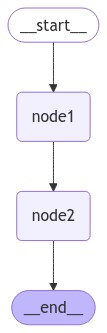

In [94]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [95]:
input_state = {'messages': [{"x": 10}]}

graph.invoke(input_state)

{'messages': [{'x': 10}]}
{'messages': [{'x': 10}, {'x': 11}]}


{'messages': [{'x': 10}, {'x': 11}, {'x': 9}]}

In [96]:
graph.invoke({'messages': [{"x": 32}]})

{'messages': [{'x': 32}]}
{'messages': [{'x': 32}, {'x': 33}]}


{'messages': [{'x': 32}, {'x': 33}, {'x': 31}]}

In [97]:
graph.invoke({'messages': [{"x": 44}]})

{'messages': [{'x': 44}]}
{'messages': [{'x': 44}, {'x': 45}]}


{'messages': [{'x': 44}, {'x': 45}, {'x': 43}]}

&emsp;&emsp;通过这样的例子我们可以理解：`Reducers` 的目的是在`LangGraph`框架中的状态管理系统中，允许更灵活地定义状态如何根据各种操作更新。通过指定不同的 `reducer` 函数，我们可以控制状态的每个部分应如何响应特定的更新。

## 1.3 在图状态中处理消息的思路

&emsp;&emsp;`Reducer`机制的一个现实意义是：我们可以基于这种方式去构建历史对话记录。因为目前大多数大模型应用都是接受消息列表作为输入。 就像`LangChain`中的`Chat Model`，需要接收`Message`对象列表作为输入。这些消息有多种形式，例如HumanMessage （用户输入）或AIMessage （ 大模型响应）。

&emsp;&emsp;下面这个示例，我们进一步将大模型接入到 `LangGraph` 工作流程中，并允许动态消息处理以及与模型的交互。其余组件与先前定义的图中的组件相同。在这里，第一个节点调用大模型并生成一个输出，该输出是一个`AIMessage`对象类型，然后，第二个节点直接将前一个节点的 `AIMessage` 提取为具体的`JSON`格式，完整代码如下：

In [103]:
import getpass
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import operator
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph,  END
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage


if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")


llm = ChatOpenAI(model='gpt-4o')


# 定义图的状态模式
class State(TypedDict):
    messages: Annotated[List[str], operator.add]

# 创建图的实例
builder = StateGraph(State)

def chat_with_model(state):
    print(state)
    print("-----------------")
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

def convert_messages(state):
    # "您是一位数据提取专家，负责从文本中检索关键信息。请为所提供的文本提取相关信息，并以 JSON 格式输出。概述所提取的关键数据点。"
    EXTRACTION_PROMPT = """
    You are a data extraction specialist tasked with retrieving key information from a text.
    Extract such information for the provided text and output it in JSON format. Outline the key data points extracted.
    """
    print(state)
    print("-----------------")
    messages = state['messages']
    messages = messages[-1] 

    messages = [
        SystemMessage(content=EXTRACTION_PROMPT),
        HumanMessage(content=state['messages'][-1].content)
    ]
    
    response = llm.invoke(messages)
    return {"messages": [response]}

# 添加节点
builder.add_node("chat_with_model", chat_with_model)
builder.add_node("convert_messages", convert_messages)

# 设置启动点
builder.set_entry_point("chat_with_model")

# 添加边
builder.add_edge("chat_with_model", "convert_messages")
builder.add_edge("convert_messages", END)

# 编译图
graph = builder.compile()

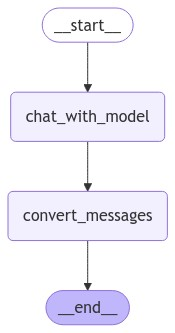

In [105]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [107]:
query="你好，请你介绍一下你自己"
input_message = {"messages": [HumanMessage(content=query)]}

result = graph.invoke(input_message)

print(result)

{'messages': [HumanMessage(content='你好，请你介绍一下你自己', additional_kwargs={}, response_metadata={})]}
-----------------
{'messages': [HumanMessage(content='你好，请你介绍一下你自己', additional_kwargs={}, response_metadata={}), AIMessage(content='你好！我是一个大型语言模型，由OpenAI开发，名为ChatGPT。我设计的目的是帮助回答各种问题，提供信息和协助解决问题。我的知识基于截至2021年9月之前的广泛数据，因此我可以回答许多关于历史、科学、文化、技术等方面的问题。不过，我没有个人经历或情感，因为我只是一个程序。如果你有什么问题或需要帮助，随时告诉我！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 14, 'total_tokens': 106, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a7d06e42a7', 'finish_reason': 'stop', 'logprobs': None}, id='run-3787c3fd-c249-497a-a753-4eca34da80c5-0', usage_metadata={'input_tokens': 14, 'output_tokens': 92, 'total_tokens': 106, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}
-----------------
{'messages': [Huma

In [109]:
print(result["messages"][-1].content)

```json
{
  "language_model": {
    "name": "ChatGPT",
    "developer": "OpenAI",
    "purpose": [
      "Answering questions",
      "Providing information",
      "Assisting with problem-solving"
    ],
    "knowledge_cutoff": "September 2021",
    "areas_of_knowledge": [
      "History",
      "Science",
      "Culture",
      "Technology"
    ],
    "attributes": [
      "No personal experiences",
      "No emotions",
      "Program-based"
    ]
  }
}
```


&emsp;&emsp;如上所示，在许多现实开发情况下，将先前的对话历史记录存储为图形状态中的消息列表是必须要做的。而实现这一功能，在`LangGraph`框架中可以向存储`Message`对象列表的图状态添加一个键（通道），并使用`Reducer`函数对其进行注释，从而告诉图在每次状态更新时（例如，当节点发送更新时）更新状态中的`Message`对象列表。如上所演示的案例中，简单地将消息追加到现有列表中，就是通过`operator.add`实现。

## 1.4 MessageGraph源码功能解析

&emsp;&emsp;更复杂一点的，如果我们还想手动更新图形状态中的消息（例如人机交互），**使用`operator.add`能做到的功能极限是：发送到图表的手动状态更新将被附加到现有的消息列表中，而不是更新现有的消息。**为了避免这种情况，我们则需要一个可以跟踪消息 ID 并覆盖现有消息（如果更新）的`Reducer`函数。为此，就引出了`LangGraph`预构建的`add_messages`函数，这个更高级的`Reducer`所实现的是：**对于全新的消息，它会附加到现有列表，但它也会正确处理现有消息的更新。如何理解这句话呢？我们接下来就从源码角度进行详细解析。**

&emsp;&emsp;上节课程中我们分析过`LangGraph` 中的 `StateGraph`类，这个类允许我们创建图，其节点通过读取和写入共享状态进行通信。 `StateGraph` 类由开发者定义的 `State` 对象进行参数化，该对象表示图中的节点将通过其进行通信的共享数据结构。

&emsp;&emsp;`MessageGraph` 是 `StateGraph` 的一个子类，使用了 `Annotated[list[AnyMessage], add_messages]` 来初始化其基类 `StateGraph`。这里的 `list[AnyMessage]` 指明了 `MessageGraph` 的状态由消息列表组成，而这个列表类型是一个可以不断添加消息的结构（因为列表是可变的数据类型），`MessageGraph` 中的每个节点都将消息列表作为输入，并返回零个或多个消息作为输出。`add_messages`函数用于将每个节点的输出消息合并进图的状态中已存在的消息列表。其源码定义如下：

> MessageGraph 源码：https://github.com/langchain-ai/langgraph/blob/e3ef9adac7395e5c0943c22bbc8a4a856b103aa3/libs/langgraph/langgraph/graph/message.py#L150

```python
class MessageGraph(StateGraph):
    def __init__(self) -> None:
        super().__init__(Annotated[list[AnyMessage], add_messages]])
```

&emsp;&emsp;`Messages`图可以单独构建，如下代码所示：

In [111]:
import getpass
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")


llm = ChatOpenAI(model="gpt-4o")

def chatbot(state: State):
    print(state)
    return {"messages": [llm.invoke(state["messages"])]}

In [113]:
from langgraph.graph.message import MessageGraph

builder = MessageGraph()

builder.add_node("chatbot", lambda state: [("assistant", "你好，最帅气的人！")])

builder.set_entry_point("chatbot")

builder.set_finish_point("chatbot")

graph = builder.compile()

In [115]:
graph.invoke([("user", "你好，请你介绍一下你自己.")])

[HumanMessage(content='你好，请你介绍一下你自己.', additional_kwargs={}, response_metadata={}, id='362af5dc-338e-4c53-81e0-3836ac83b3d5'),
 AIMessage(content='你好，最帅气的人！', additional_kwargs={}, response_metadata={}, id='9d631688-af5f-4daa-b00b-4362392f6730')]

In [117]:
graph.invoke([("user", "Hi 3213.")])

[HumanMessage(content='Hi 3213.', additional_kwargs={}, response_metadata={}, id='b4ef7019-7074-4029-8177-75ed28b2957c'),
 AIMessage(content='你好，最帅气的人！', additional_kwargs={}, response_metadata={}, id='8968e345-1d04-4138-998d-65b66cabb107')]

&emsp;&emsp;MessageGraph通过使用单个仅附加消息列表作为其整个状态来管理状态，其中每个节点处理该列表并可以返回其他消息。这种设计特别适合对话式应用程序，可以轻松跟踪对话历史和交互。

&emsp;&emsp;继而进一步来看`add_messages`这个`Reducer`函数的定义情况：

```python

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


def add_messages(left: Messages, right: Messages) -> Messages:
    """Merges two lists of messages, updating existing messages by ID.

    By default, this ensures the state is "append-only", unless the
    new message has the same ID as an existing message.

    Args:
        left: The base list of messages.
        right: The list of messages (or single message) to merge
            into the base list.

    Returns:
        A new list of messages with the messages from `right` merged into `left`.
        If a message in `right` has the same ID as a message in `left`, the
        message from `right` will replace the messagage(content='Hello', id=...)]}
        ```

    """
    # coerce to list
    if not isinstance(left, list):
        left = [left]  # type: ignore[assignment]
    if not isinstance(right, list):
        right = [right]  # type: ignore[assignment]
    # coerce to message
    left = [
        message_chunk_to_message(cast(BaseMessageChunk, m))
        for m in convert_to_messages(left)
    ]
    right = [
        message_chunk_to_message(cast(BaseMessageChunk, m))
        for m in convert_to_messages(right)
    ]
    # assign missing ids
    for m in left:
        if m.id is None:
            m.id = str(uuid.uuid4())
    for m in right:
        if m.id is None:
            m.id = str(uuid.uuid4())
    # merge
    left_idx_by_id = {m.id: i for i, m in enumerate(left)}
    merged = left.copy()
    ids_to_remove = set()
    for m in right:
        if (existing_idx := left_idx_by_id.get(m.id)) is not None:
            if isinstance(m, RemoveMessage):
                ids_to_remove.add(m.id)
            else:
                merged[existing_idx] = m
        else:
            if isinstance(m, RemoveMessage):
                raise ValueError(
                    f"Attempting to delete a message with an ID that doesn't exist ('{m.id}')"
                )

            merged.append(m)
    merged = [m for m in merged if m.id not in ids_to_remove]
    return merged
```

> LangGraph add_messages：https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages

&emsp;&emsp;`add_messages`整体的核心逻辑是合并两个消息列表，按 `ID` 更新现有消息。默认情况下，状态为“仅附加”，当新消息与现有消息具有相同的 ID时，进行更新。具体参数是：
- left （ Messages ） – 消息的基本列表。
- right （ Messages ） – 要合并到基本列表中的消息列表（或单个消息）。

&emsp;&emsp;而返回值是一个消息列表，其中的合并逻辑则是：如果right的消息与left的消息具有相同的 ID，则right的消息将替换left的消息，否则作为一条新的消息进行追加。

In [120]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

msgs1 = [HumanMessage(content="你好。", id="1")]
msgs2 = [AIMessage(content="你好，很高兴认识你。", id="2")]

add_messages(msgs1, msgs2)

[HumanMessage(content='你好。', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='你好，很高兴认识你。', additional_kwargs={}, response_metadata={}, id='2')]

In [122]:
msgs1 = [HumanMessage(content="你好。", id="1")]
msgs2 = [HumanMessage(content="你好呀。", id="1")]

add_messages(msgs1, msgs2)

[HumanMessage(content='你好呀。', additional_kwargs={}, response_metadata={}, id='1')]

&emsp;&emsp;消息状态管理不仅可以在`MessageGraph`中定义，还可以在`StateGraph`中定义。相比之下， `StateGraph`允许更复杂的状态结构，其中状态可以是任何 Python 类型（如 TypedDict 或 Pydantic 模型），并且可以通过各种方式更新。 `StateGraph` 中的每个节点都会接收当前状态并返回更新后的状态，从而实现除消息处理之外的更复杂的数据操作和工作流程。因此，`MessageGraph` 专门用于以消息为中心的工作流程，而 `StateGraph` 则更通用，适用于更广泛的应用程序。

&emsp;&emsp;所以，对于人机交互的程序，在`LangGraph`的开发流程中，我们一般会首先创建一个`StateGraph` , `StateGraph`对象将应用程序的结构定义为“状态机”，比如下面的这个接入大模型的聊天机器人：

In [124]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

&emsp;&emsp;`State`是一个带有单个键的`TypedDict` ： `messages` 。 `messages`键使用`add_messages`作为`Reducer`函数告诉 `LangGraph` 将新消息追加到现有列表中，而不是覆盖它。

In [128]:
import getpass
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")


llm = ChatOpenAI(model="gpt-4o")

def chatbot(state: State):
    # print(state)
    return {"messages": [llm.invoke(state["messages"])]}

&emsp;&emsp;接下来，添加一个`chatbot`节点，将当前`State`作为输入并返回一个字典，该字典中更新了`messages`中的状态信息。

In [131]:
graph_builder.add_node("chatbot", chatbot)

In [133]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

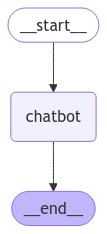

In [135]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

&emsp;&emsp;通过一个程序构建可交互式的聊天机器人。完整代码如下：

In [139]:
def stream_graph_updates(user_input: str):  
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("模型回复:", value["messages"][-1].content)


while True:
    try:
        user_input = input("用户提问: ")
        if user_input.lower() in ["退出"]:
            print("下次再见！")
            break

        stream_graph_updates(user_input)
    except:
        break

用户提问:  你好，请你介绍一下你自己


模型回复: 你好！我是一个大型语言模型助手，由OpenAI开发，旨在帮助回答问题、提供信息和协助解决各种任务。我可以处理广泛的主题，包括科学、历史、技术、文化等等。无论你有什么问题，尽管问，我会尽力提供准确和有用的回答。


用户提问:  你都能做什么呀


模型回复: 我可以帮助你回答各种问题、提供信息、协助解决问题、给出建议、翻译文本、进行语言练习、甚至闲聊等。如果你有任何具体的问题或任务，请随时告诉我！


用户提问:  退出


下次再见！


&emsp;&emsp;掌握`State`的定义模式和消息传递是`LangGraph`中最关键，也是构建应用最核心的部分，所有的高阶功能，如工具调用、上下文记忆，人机交互等依赖`State`的管理和使用，所以大家务必理解并掌握上述相关内容。这一部分我们在下一节课中展开详细的介绍，接下来我们先给大家介绍一个实用的开发工具：LangSmith。

# 2. LangSmith基础使用入门

&emsp;&emsp;大模型具有不确定性，尤其是构建复杂`AI Agent`应用程序中，中间会涉及非常多的子步骤，如果想要了解每一步的运行状态和结果，一方面可以通过`Debug`来进行实时控制，而另一方面可以借助一些工具来观察和调试中间的交互流程。`Langsmith`就是这样一个工具平台， 由​​ `LangChain` 和 `LangGraph` 背后的团队创建，**主要作用是：为基于大语言模型构建的应用程序提供全面的监控、调试和可观察性。提供强大的跟踪、日志记录和实时分析功能。**


> LangSmith：https://smith.langchain.com/

&emsp;&emsp;通常，对于一个项目而言，可以是单个应用程序或服务。该项目将包含多个跟踪，每个跟踪都是运行的集合 - 一个运行代表应用程序中的一个基本操作，例如对 OpenAI 的 API 调用，或检索操作。如下图所示：

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022164041124.png" width=100%></div>

- **Project (项目)：**蓝色方块代表整个项目，可能是一个单独的应用程序或服务。
- **Traces (轨迹)：**绿色方块代表项目在不同条件或配置下的执行路径。每个轨迹可以是一个特定的用户会话、一个功能的执行，或者应用在特定输入下的行为。
- **Runs (运行)：**每个轨迹下的黄色方块表示特定轨迹的单次执行。这些是执行的实例，每个实例都是轨迹在特定条件下的实际运行。
- **Feedback, Tags, Metadata (反馈、标签、元数据)：**这部分显示了系统如何利用用户或自动化工具生成的反馈、标签和元数据来增强轨迹的管理和过滤。反馈可以用于改进未来的运行，标签和元数据可用于分类和筛选特定的轨迹或运行，以便在LangSmith的用户界面中更容易地管理和审查

&emsp;&emsp;我们使用当前的简单 `LangGraph` 作为示例：

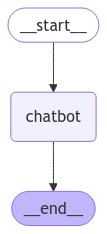

In [214]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

&emsp;&emsp;跟踪是请求通过图逻辑的步骤的详细记录。将其视为显示从开始到结束的确切顺序的路线图，在当前的设置中，`LangGraph` 很简单：
- 它以__start__节点开始
- 穿过 AI 生成回复的response节点
- 结束于__end__节点。

&emsp;&emsp;每次用户与程序进行交互时，该图都会展开，并且此过程中的每个步骤都会记录为跟踪的一部分。借助 `Langsmith`，我们可以实时可视化和分析这些痕迹。设置 `Langsmith`并不复杂，我们需要依次执行如下操作步骤。

- **Step 1. 创建一个 LangSmith 帐户**

&emsp;&emsp;要开始使用 `LangSmith`，我们需要创建一个帐户。可以在这里注册一个免费帐户进入`LangSmith`登录页面： https://smith.langchain.com/， 支持使用 Google、GitHub、Discord 和电子邮件登录。

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022165215709.png" width=100%></div>

&emsp;&emsp;注册并等登录后，可以直接查看到仪表板：

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022165247933.png" width=100%></div>

&emsp;&emsp;在构建程序跟踪前，首先需要创建一个 `API` 密钥，该密钥将允许我们的项目开始向 `Langsmith` 发送跟踪数据。

- **Step 2. 创建 API 密钥**

&emsp;&emsp;单击 `Langsmith` 仪表板左侧菜单中的“设置”图标。

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022165343038.png" width=100%></div>

&emsp;&emsp;导航至“API 密钥”部分，然后单击“创建 API 密钥” 。

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022165421182.png" width=100%></div>

&emsp;&emsp;`LangSmith` 支持两种类型的 API 密钥：服务密钥和个人访问令牌。两种类型的令牌都可用于验证对 `LangSmith API` 的请求，但它们有不同的用例。这里选择“密钥类型令牌的个人访问” ，因为我们将使用此密钥作为用户进行个人访问。

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022165455845.png" width=100%></div>

&emsp;&emsp;单击“创建 API 密钥” ，复制并确认已保存。这和`OpenAI`的`API`密钥一样，一旦创建完成，则不允许再次复制。

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022165542782.png" width=100%></div>

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022165638427.png" width=100%></div>

&emsp;&emsp;现在，就可以将其集成到我们的项目中了。

- **Step 3. 创建环境变量**

&emsp;&emsp;将`LANGCHAIN_API_KEY`替换为我们刚刚创建的 `API` 密钥。

In [1]:
import os

# 设置环境变量
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"

# 验证环境变量是否设置成功
print(os.getenv("LANGCHAIN_TRACING_V2"))
print(os.getenv("LANGCHAIN_API_KEY"))

true
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


&emsp;&emsp;在环境变量中设置以后，我们的代码不需要做任何的改变，即可构建`LangSmith`的消息跟踪。

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import getpass
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")


llm = ChatOpenAI(model="gpt-4o")

def chatbot(state: State):
    # print(state)
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [5]:
def stream_graph_updates(user_input: str):  
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("模型回复:", value["messages"][-1].content)


while True:
    try:
        user_input = input("用户提问: ")
        if user_input.lower() in ["退出"]:
            print("下次再见！")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available  
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

用户提问:  你好


模型回复: 你好！有什么我可以帮助你的吗？


用户提问:  请你介绍一下你自己


模型回复: 当然可以！我是一个大型语言模型，由OpenAI开发，名为ChatGPT。我是基于人工智能技术的对话系统，设计的目的是与人类进行自然语言交流。我可以帮助回答问题，提供信息，协助解决问题，并进行各种主题的讨论。我的知识库涵盖了广泛的主题，包括科学、技术、历史、文化等，但请注意，我的知识更新到2023年10月，因此对于之后发生的事件或发布的信息可能不了解。如果你有任何问题或需要帮助，随时可以问我！


用户提问:  退出


下次再见！


&emsp;&emsp;然后即可在控制面板上实时查看到该应用程序执行过程中各个状态的输入和输出情况。

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241023151932199.png" width=100%></div>

&emsp;&emsp;至此，大家已经可以运行起`LangSmith`应用工具。在初次构建AI应用程序时，建议从最简单的工作流实现开始，结合 `LangSmith` 这样的评估工具是能够极大程度上帮助大家理解其中间过程。而随着构建应用程序的越来越复杂，其中间状态也会变得越来越多。在接下来的课程中，我们会随着新功能点的讲解，再展开对`LangSmith`使用方法和各项指标的具体说明。